# Vocal separation

This notebook demonstrates a simple, but effective technique for separating vocals (and other sporadic foreground signals) from accompanying instrumentation.

Based on the method of [Rafii and Pardo, 2012](http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf), but includes a couple of modifications and extensions:

- fft windows are 1/4 overlap, instead of 1/2
- non-local filtering is converted into a soft mask by Wiener filtering.  This is similar in spirit to the soft-masking method used by [Fitzgerald, 2012](http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon), but is a bit more numerically stable in practice.

In [1]:
from __future__ import print_function

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
import librosa.display
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

In [3]:
# Load an example with vocals
y, sr = librosa.load('audio/Cheese_N_Pot-C_-_16_-_The_Raps_Well_Clean_Album_Version.mp3',
                     sr=44100, offset=20, duration=30)

In [4]:
#S_full, phase = librosa.magphase(librosa.stft(y, n_fft=2048, hop_length=2048, window=np.ones))
S_full, phase = librosa.magphase(librosa.stft(y, hop_length=2048, window=np.ones))

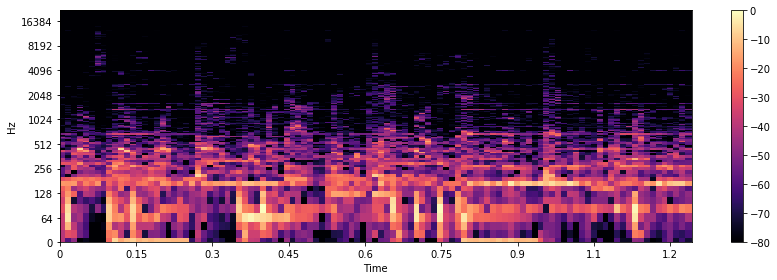

In [6]:
# Plot a 5-second slice of the spectrum
idx = slice(*librosa.time_to_frames([10, 15], hop_length=2048, sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx]**2, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

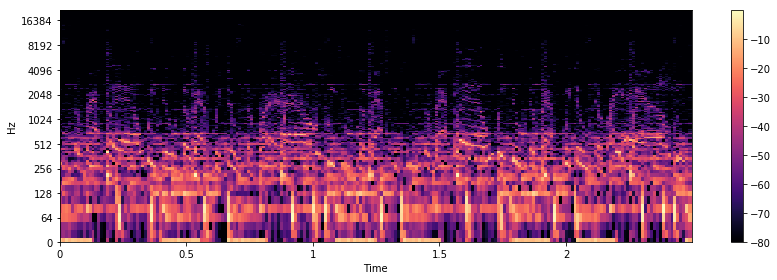

In [9]:
# Plot a 5-second slice of the spectrum
idx = slice(*librosa.time_to_frames([10, 15], hop_length=1024, sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx]**2, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

#### The wiggly lines above are due to the vocal component.  We can separate them by using non-local median filtering.

In [10]:
Audio(data=y, rate=sr)

In [11]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       k=20,
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input if we assume signals are additive
S_filter = np.minimum(S_full, S_filter)

In [12]:
# The raw filter output can be used as a mask, but it sounds better if we use soft-masking.
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.

# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Using the masks we get a cleaner signal

S_foreground = mask_v * S_full
S_background = mask_i * S_full

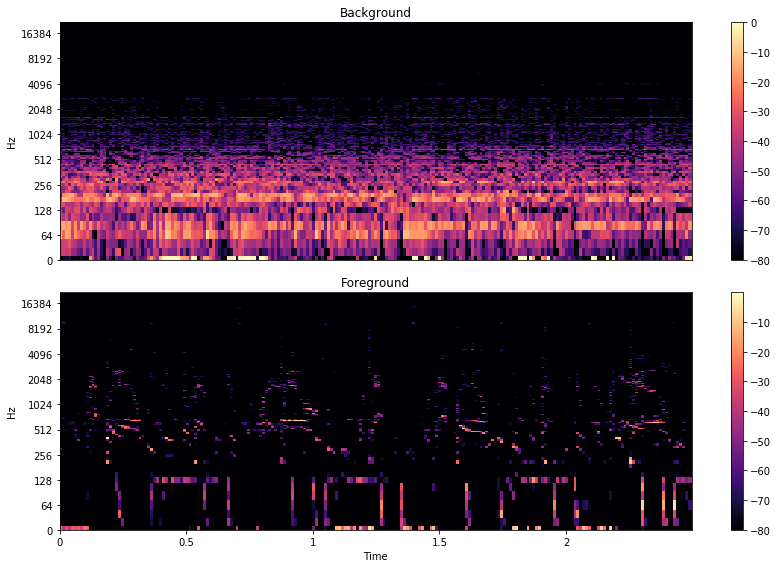

In [14]:
# Plot the same slice, but separated into its foreground and background

plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx]**2, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx]**2, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()

#### And play them back in order: full, background, foreground (vocals)

In [15]:
Audio(data=y, rate=sr)

In [16]:
Audio(data=librosa.istft(S_background * phase), rate=sr)

In [17]:
Audio(data=librosa.istft(S_foreground * phase), rate=sr)